# **Optimizer Comparison**

Goal: compare CRAB optimizers on a shared configuration, report convergence/runtime, and evaluate robustness against detuning and pulse-area variations.
Quickstart: edit the Parameter Panel, run all cells, then review the Results Summary.

Sections:
- [Parameter Panel](#Parameter-Panel)
- [Run Batch](#Run-Batch)
- [Convergence Overlays](#Convergence-Overlays)
- [Runtime Table](#Runtime-Table)
- [Apples-to-Apples Evaluation](#Apples-to-Apples-Evaluation)
- [Robustness Heatmaps](#Robustness-Heatmaps)
- [Results Summary](#Results-Summary)
- [Troubleshooting](#Troubleshooting)


## Imports


In [1]:
# Imports
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys, os


# Assume this notebook lives in project_root/notebooks/
notebook_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
repo_root = notebook_dir.parent if notebook_dir.name == "notebooks" else notebook_dir
# Allow the notebook to import project modules when executed interactively.
if str(repo_root) not in map(str, sys.path):
    sys.path.insert(0, str(repo_root))
os.chdir(repo_root)

from src import (
    ExperimentConfig,
    override_from_dict,
    run_experiment,
    Result,
    TimeGridSpec,
    PulseShapeSpec,
    BasisSpec,
    GrapeBaselineConfig,
    build_grape_baseline,
)



In [ ]:
# Baseline configuration (mirrors Quickstart defaults)
time_grid = {"duration_us": 0.1, "num_points": 2001}
omega_shape = {"kind": "polynomial", "area_pi": 1.0}
delta_shape = {"kind": "linear_chirp", "area_pi": 0.0, "amplitude_scale": 0.5}
basis_config = {"num_omega": 6, "num_delta": 0}

rho0 = np.array([[1.0, 0.0], [0.0, 0.0]], dtype=np.complex128)
target = np.array([[0.0, 0.0], [0.0, 1.0]], dtype=np.complex128)



In [ ]:
# Build baseline arrays used across optimizer comparisons
_time_spec = TimeGridSpec(**time_grid)
_basis_spec = BasisSpec(**basis_config)
_omega_spec = PulseShapeSpec(**omega_shape)
_delta_spec = PulseShapeSpec(**delta_shape) if delta_shape is not None else None

baseline_config = GrapeBaselineConfig(
    time_grid=_time_spec,
    omega=_omega_spec,
    delta=_delta_spec,
    basis=_basis_spec,
    rho0=rho0,
    target=target,
)

baseline_arrays, baseline_metadata = build_grape_baseline(baseline_config)
baseline_params = baseline_config.to_dict()



## Parameter Panel


In [ ]:
# @title Parameter Panel
arrays = baseline_arrays
T_us = float(arrays["T"])
Nt = int(arrays["Nt"])
t_us = arrays["t"].astype(float)
delta0 = arrays["Delta0"].astype(float)
frequencies_omega = arrays["omega_frequencies_rad_per_us"].tolist()
default_K = len(frequencies_omega)

delta_max_rad_per_us = float(np.abs(delta0).max())
delta_max_MHz = delta_max_rad_per_us / (2 * np.pi)

user_params = {
    'run_name_prefix': 'comparison',
    'output_dir': 'results/optimizer_comparison',
    'methods': ['adam', 'const', 'linesearch'],
    'method_settings': {
        'adam': {'max_iters': 1000, 'learning_rate': 0.05, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8, 'grad_clip': None},
        'const': {'max_iters': 1000, 'learning_rate': 0.02, 'grad_clip': None},
        'linesearch': {'max_iters': 1000, 'alpha0': 0.2, 'ls_beta': 0.5, 'ls_sigma': 1e-4, 'ls_max_backtracks': 12, 'grad_clip': None},
    },
    'penalties': {'w_power': 1.0e-4, 'w_neg': 1.0, 'neg_kappa': 10.0},
    'crab': {
        'K': default_K,
        'omegas_rad_per_us': frequencies_omega,
        'phases': [0.0] * default_K,
        'use_delta': arrays['CRAB_BASIS_DELTA'].shape[1] > 0,
    },
    'path_objective': {'method': 'adam', 'max_iters': 1000},
    'ensemble_objective': {'method': 'adam', 'max_iters': 1000},
}

BASE_OVERRIDES = {
    'baseline': {'name': 'comparison', 'params': baseline_params},
    'run_name': user_params['run_name_prefix'],
    'artifacts_root': str(Path(user_params['output_dir']).resolve()),
    'optimizer_options': {
        'method': 'adam',
        'max_iters': user_params['method_settings']['adam']['max_iters'],
        'learning_rate': user_params['method_settings']['adam']['learning_rate'],
        'beta1': user_params['method_settings']['adam']['beta1'],
        'beta2': user_params['method_settings']['adam']['beta2'],
        'epsilon': user_params['method_settings']['adam']['epsilon'],
        'grad_clip': user_params['method_settings']['adam']['grad_clip'],
        'optimize_delta': bool(user_params['crab']['use_delta']),
        'K': int(user_params['crab']['K']),
        'omegas_rad_per_us': user_params['crab']['omegas_rad_per_us'],
        'phases': user_params['crab']['phases'],
    },
    'penalties': {
        'power_weight': float(user_params['penalties']['w_power']),
        'neg_weight': float(user_params['penalties']['w_neg']),
        'neg_kappa': float(user_params['penalties']['neg_kappa']),
    },
    'metadata': {
        'objective': 'terminal',
        'path_params': {'reference': 'adiabatic_ground_state'},
        'ensemble_params': {
            'beta_min': 0.9,
            'beta_max': 1.1,
            'num_beta': 5,
            'detuning_MHz_min': -delta_max_MHz,
            'detuning_MHz_max': delta_max_MHz,
            'num_detuning': 5,
        },
        'baseline_metadata': baseline_metadata,
    },
}

print('Methods:', user_params['methods'])
print('Path objective settings:', user_params['path_objective'])
print('Ensemble objective settings:', user_params['ensemble_objective'])
print('Penalties:', user_params['penalties'])



Methods: ['adam', 'const', 'linesearch']
Path objective settings: {'method': 'adam', 'max_iters': 300}
Ensemble objective settings: {'method': 'adam', 'max_iters': 300}
Penalties: {'w_power': 0.0001, 'w_neg': 1.0, 'neg_kappa': 10.0}


## Run Batch


In [3]:
# @title Run Batch
from copy import deepcopy

OUTPUT_DIR = Path(user_params['output_dir']).resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = OUTPUT_DIR / 'figures'
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Collect results and metadata for downstream comparison plots.
results_store = {}
terminal_runs = {}

base_config = override_from_dict(ExperimentConfig(), BASE_OVERRIDES)
problem, _, _ = load_crab_problem(base_config)

omega_baseline = problem.omega_base
if problem.delta_base is None:
    delta_baseline = np.zeros_like(omega_baseline)
else:
    delta_baseline = problem.delta_base

baseline_cost, _ = accumulate_cost_and_grads(
    omega_baseline,
    delta_baseline,
    problem.dt_us,
    psi0=problem.psi0,
    psi_target=problem.psi_target,
    w_power=0.0,
    w_neg=0.0,
)
results_store['baseline'] = {
    'objective': 'baseline',
    'metrics': {
        'terminal': float(baseline_cost.get('terminal', 0.0)),
        'total': float(baseline_cost.get('terminal', 0.0)),
        'terminal_eval': float(baseline_cost.get('terminal', 0.0)),
    },
    'pulses': {'omega': omega_baseline, 'delta': delta_baseline},
    'artifacts_dir': None,
}


def build_overrides(objective: str, method: str, method_opts: dict, suffix: str) -> dict:
    """Clone the base overrides and inject objective-specific options."""
    overrides = json.loads(json.dumps(BASE_OVERRIDES))
    # JSON round-trip yields a deep copy so nested dictionaries stay isolated.
    overrides['run_name'] = f"{user_params['run_name_prefix']}-{objective}-{method}-{suffix}"
    overrides['optimizer_options'].update(method_opts)
    overrides['optimizer_options']['method'] = method
    overrides['metadata']['objective'] = objective
    return overrides

# Terminal runs for each method
for method in user_params['methods']:
    method_opts = deepcopy(user_params['method_settings'][method])
    overrides = build_overrides('terminal', method, method_opts, 'opt')
    cfg = override_from_dict(ExperimentConfig(), overrides)
    result = run_experiment(cfg, method=method, exist_ok=True)
    terminal_runs[method] = result
    results_store[f"terminal_{method}"] = {
        'objective': 'terminal',
        'result': result,
    }

# Path optimisation (single method)
path_method = user_params['path_objective'].get('method', 'adam')
path_opts = deepcopy(user_params['method_settings'][path_method])
path_opts.update({k: v for k, v in user_params['path_objective'].items() if k != 'method'})
path_overrides = build_overrides('path', path_method, path_opts, 'opt')
cfg_path = override_from_dict(ExperimentConfig(), path_overrides)
path_result = run_experiment(cfg_path, method=path_method, exist_ok=True)
results_store['path'] = {'objective': 'path', 'result': path_result}

# Ensemble optimisation (single method)
ensemble_method = user_params['ensemble_objective'].get('method', 'adam')
ensemble_opts = deepcopy(user_params['method_settings'][ensemble_method])
ensemble_opts.update({k: v for k, v in user_params['ensemble_objective'].items() if k != 'method'})
ensemble_overrides = build_overrides('ensemble', ensemble_method, ensemble_opts, 'opt')
cfg_ens = override_from_dict(ExperimentConfig(), ensemble_overrides)
ensemble_result = run_experiment(cfg_ens, method=ensemble_method, exist_ok=True)
results_store['ensemble'] = {'objective': 'ensemble', 'result': ensemble_result}

print('Completed runs:')
for key, entry in results_store.items():
    if key == 'baseline':
        print('  baseline (no artifacts)')
    else:
        res = entry['result']
        print(f"  {key}: status={res.optimizer_state.get('status')} -> {res.artifacts_dir}")


Completed runs:
  baseline (no artifacts)
  terminal_adam: status=max_iters -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-terminal-adam-opt
  terminal_const: status=converged_rtol -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-terminal-const-opt
  terminal_linesearch: status=converged_rtol -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-terminal-linesearch-opt
  path: status=max_iters -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-path-adam-opt
  ensemble: status=max_iters -> C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-ensemble-adam-opt


## Convergence Overlays


In [4]:
# @title Convergence Overlays
conv_paths = []
plt.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(figsize=(7, 5))
for method, result in terminal_runs.items():
    total = result.history.get('total')
    if total is None or len(total) == 0:
        continue
    iterations = result.history.get('iter')
    if iterations is None or len(iterations) != len(total):
        iterations = np.arange(1, len(total) + 1)
    ax.semilogy(iterations, total, label=method)
ax.set_xlabel('Iteration')
ax.set_ylabel('Total cost')
ax.set_title('Cost vs iteration (terminal objective)')
ax.grid(True, which='both', ls=':', alpha=0.6)
ax.legend()
conv_file = FIGURES_DIR / 'convergence_cost_vs_iteration.png'
fig.savefig(conv_file, dpi=300, bbox_inches='tight')
plt.close(fig)
conv_paths.append(conv_file)

calls_file = None
if any('calls_per_iter' in res.history for res in terminal_runs.values()):
    fig, ax = plt.subplots(figsize=(7, 5))
    for method, result in terminal_runs.items():
        total = result.history.get('total')
        calls = result.history.get('calls_per_iter')
        if total is None or calls is None or len(total) == 0:
            continue
        calls = np.asarray(calls)
        if calls.size != len(total):
            calls = np.arange(1, len(total) + 1)
        ax.semilogy(calls, total, label=method)
    ax.set_xlabel('Oracle calls')
    ax.set_ylabel('Total cost')
    ax.set_title('Cost vs oracle calls (terminal objective)')
    ax.grid(True, which='both', ls=':', alpha=0.6)
    ax.legend()
    calls_file = FIGURES_DIR / 'convergence_cost_vs_calls.png'
    fig.savefig(calls_file, dpi=300, bbox_inches='tight')
    plt.close(fig)
    conv_paths.append(calls_file)

fig, ax = plt.subplots(figsize=(7, 5))
for method, result in terminal_runs.items():
    grad = result.history.get('grad_norm')
    if grad is None or len(grad) == 0:
        continue
    iterations = result.history.get('iter')
    if iterations is None or len(iterations) != len(grad):
        iterations = np.arange(1, len(grad) + 1)
    ax.semilogy(iterations, grad, label=method)
ax.set_xlabel('Iteration')
ax.set_ylabel('Gradient norm')
ax.set_title('Gradient norm vs iteration (terminal objective)')
ax.grid(True, which='both', ls=':', alpha=0.6)
ax.legend()
grad_file = FIGURES_DIR / 'convergence_grad_vs_iteration.png'
fig.savefig(grad_file, dpi=300, bbox_inches='tight')
plt.close(fig)
conv_paths.append(grad_file)

print('Saved convergence overlays:')
for path in conv_paths:
    print(' ', path)


Saved convergence overlays:
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\convergence_cost_vs_iteration.png
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\convergence_cost_vs_calls.png
  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\convergence_grad_vs_iteration.png


## Runtime Table


In [5]:
# @title Runtime Table
print(f"{'method':>12}  {'iters':>6}  {'runtime_s':>12}  {'total_cost':>12}")
for method, result in terminal_runs.items():
    iterations = len(result.history.get('iter', []))
    runtime_s = float(result.final_metrics.get('runtime_s', float('nan')))
    total_cost = float(result.final_metrics.get('total', float('nan')))
    print(f"{method:>12}  {iterations:6d}  {runtime_s:12.3f}  {total_cost:12.6f}")


      method   iters     runtime_s    total_cost
        adam     300         1.470      0.308542
       const       2         0.015      0.400546
  linesearch       2         0.019      0.400483


## Apples-to-Apples Evaluation


In [6]:
# @title Apples-to-Apples Terminal Evaluation
from collections import OrderedDict

def terminal_eval_from_result(result: Result) -> float:
    """Re-evaluate terminal infidelity with penalties disabled for apples-to-apples."""
    omega = np.asarray(result.pulses['omega'], dtype=float)
    delta = np.asarray(result.pulses.get('delta'))
    if delta is None:
        delta = np.asarray(problem.delta_base, dtype=float)
    cost_eval, _ = accumulate_cost_and_grads(
        omega,
        delta,
        problem.dt_us,
        psi0=problem.psi0,
        psi_target=problem.psi_target,
        w_power=0.0,
        w_neg=0.0,
    )
    return float(cost_eval.get('terminal', float('nan')))

terminal_eval_table = OrderedDict()
terminal_eval_table['baseline'] = terminal_eval_from_result(Result(
    run_name='baseline',
    artifacts_dir=None,
    config=base_config,
    history={},
    final_metrics={},
    pulses={'omega': omega_baseline, 'delta': delta_baseline, 't_us': t_us, 'omega_base': omega_baseline, 'delta_base': delta_baseline, 'coeffs': np.zeros_like(omega_baseline)},
    optimizer_state={},
))

for method, result in terminal_runs.items():
    terminal_eval_table[f'terminal_{method}'] = terminal_eval_from_result(result)

terminal_eval_table['path'] = terminal_eval_from_result(path_result)
terminal_eval_table['ensemble'] = terminal_eval_from_result(ensemble_result)

print(f"{'run':>20}  {'terminal_infidelity':>20}")
for label, value in terminal_eval_table.items():
    print(f"{label:>20}  {value:20.6f}")


                 run   terminal_infidelity
            baseline              0.065390
       terminal_adam              0.001722
      terminal_const              0.065380
 terminal_linesearch              0.065298
                path              0.029295
            ensemble              0.003428


## Robustness Heatmaps


Heatmap outputs:
   C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\heatmap_terminal_vs_detuning_area_4panel.png
   C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\heatmap_terminal_vs_detuning_area_4panel.svg
   C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\heatmap_terminal_vs_detuning_area_baseline.png
   C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\heatmap_terminal_vs_detuning_area_baseline.svg
   C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\robustness_terminal_vs_detuning_area_baseline.npz
   C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\heatmap_terminal_vs_detuning_area_terminal.png
   C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\figures\heatmap_terminal_vs_detuning_area_terminal.svg
   C:\Users

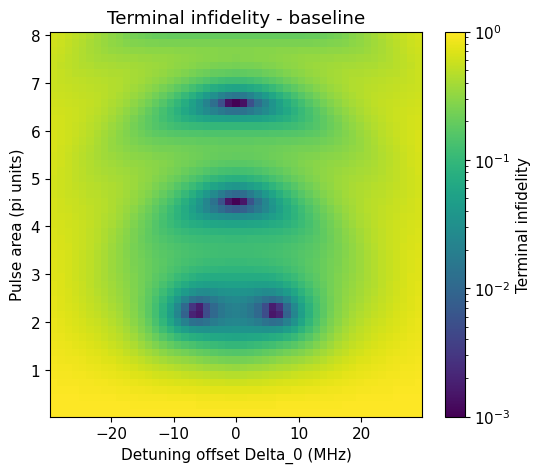

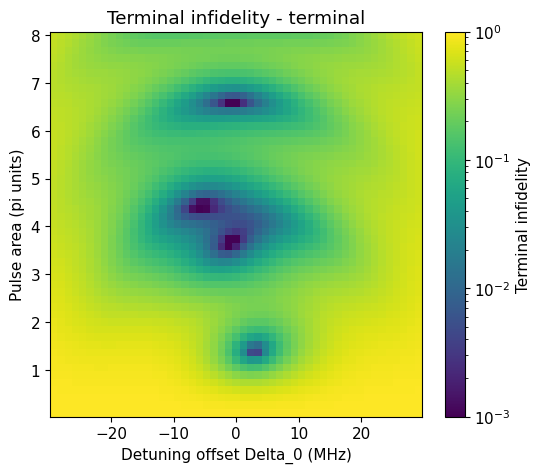

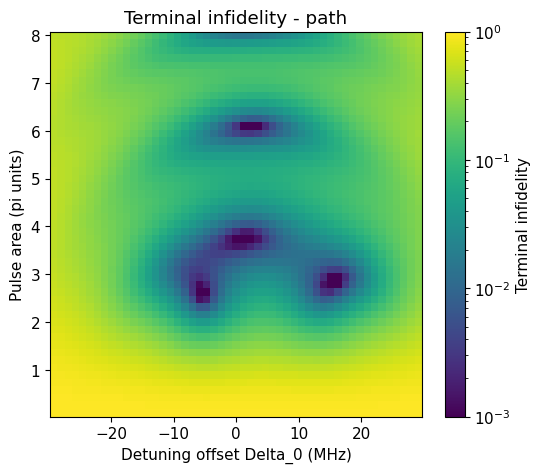

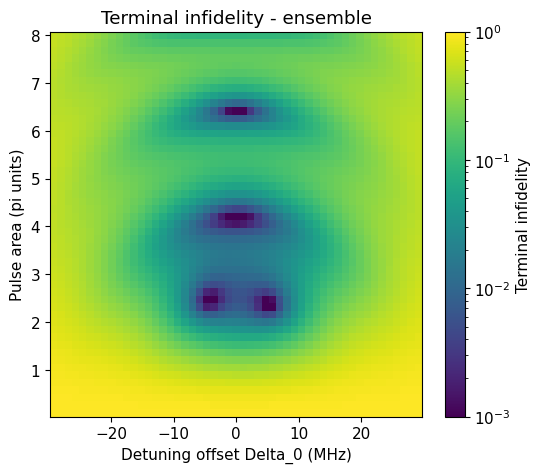

In [7]:
# @title Robustness Heatmaps
detuning_MHz_grid = np.linspace(-delta_max_MHz, delta_max_MHz, 51)
area_pi_grid = np.linspace(0.1, 8.0, 51)

heatmap_inputs = {
    'baseline': {'omega': omega_baseline, 'delta': delta_baseline, 'title': 'Baseline'},
}

best_terminal_label = None
best_terminal_value = float('inf')
for method, result in terminal_runs.items():
    value = terminal_eval_table[f'terminal_{method}']
    heatmap_inputs[f'terminal_{method}'] = {
        'omega': np.asarray(result.pulses['omega'], dtype=float),
        'delta': np.asarray(result.pulses.get('delta', delta_baseline), dtype=float),
        'title': f'Terminal ({method})',
    }
    if value < best_terminal_value:
        best_terminal_value = value
        best_terminal_label = f'terminal_{method}'

heatmap_inputs['path'] = {
    'omega': np.asarray(path_result.pulses['omega'], dtype=float),
    'delta': np.asarray(path_result.pulses.get('delta', delta_baseline), dtype=float),
    'title': 'Path optimised',
}
heatmap_inputs['ensemble'] = {
    'omega': np.asarray(ensemble_result.pulses['omega'], dtype=float),
    'delta': np.asarray(ensemble_result.pulses.get('delta', delta_baseline), dtype=float),
    'title': 'Ensemble optimised',
}

panel_labels = [
    ('baseline', heatmap_inputs['baseline']),
    ('terminal', heatmap_inputs[best_terminal_label]),
    ('path', heatmap_inputs['path']),
    ('ensemble', heatmap_inputs['ensemble']),
]

inf_cache = {}
finite_values = []
for label, info in panel_labels:
    _, inf = plot_robustness_heatmap(
        {'omega': info['omega'], 'delta': info['delta']},
        t_us,
        delta_baseline,
        detuning_MHz_grid,
        area_pi_grid,
        label=label,
        psi0=problem.psi0,
        target=problem.psi_target,
        save_dir=FIGURES_DIR,
        save=True,
    )
    inf_cache[label] = inf
    finite_vals = inf[np.isfinite(inf) & (inf > 0.0)]
    if finite_vals.size:
        finite_values.append(finite_vals.min())
        finite_values.append(finite_vals.max())

if finite_values:
    vmin = min(finite_values)
    vmax = max(finite_values)
else:
    vmin, vmax = 1e-3, 1.0
vmin, vmax = 1e-3, 1.0
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ax, (label, info) in zip(axes, panel_labels):
    inf = inf_cache[label]
    X, Y = np.meshgrid(detuning_MHz_grid, area_pi_grid)
    mesh = ax.pcolormesh(X, Y, inf, shading='auto', cmap='viridis', norm=LogNorm(vmin=max(vmin, 1e-3), vmax=max(vmax, 1.0)))
    ax.set_title(info['title'])
    ax.set_xlabel('Detuning offset Î”â‚€ (MHz)')
    ax.set_ylabel('Pulse area (Ï€ units)')

fig.subplots_adjust(right=0.88, hspace=0.25)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(mesh, cax=cbar_ax).set_label('Terminal infidelity')
combined_heatmap = FIGURES_DIR / 'heatmap_terminal_vs_detuning_area_4panel.png'
fig.savefig(combined_heatmap, dpi=300, bbox_inches='tight')
fig.savefig(combined_heatmap.with_suffix('.svg'), bbox_inches='tight')
plt.close(fig)

print('Heatmap outputs:')
print('  ', combined_heatmap)
print('  ', combined_heatmap.with_suffix('.svg'))
for label, _ in panel_labels:
    print('  ', FIGURES_DIR / f'heatmap_terminal_vs_detuning_area_{label}.png')
    print('  ', FIGURES_DIR / f'heatmap_terminal_vs_detuning_area_{label}.svg')
    print('  ', FIGURES_DIR / f'robustness_terminal_vs_detuning_area_{label}.npz')


## Results Summary


In [8]:
# @title Results Summary
from pathlib import Path

print(f"{'label':>20}  {'objective':>10}  {'iters':>6}  {'total_cost':>12}  {'terminal_eval':>20}  artifacts")

print(f"{'baseline':>20}  {'baseline':>10}  {'n/a':>6}  {results_store['baseline']['metrics']['total']:12.6f}  {results_store['baseline']['metrics']['terminal_eval']:20.6f}  -")

for method, result in terminal_runs.items():
    iterations = len(result.history.get('iter', []))
    total_cost = float(result.final_metrics.get('total', float('nan')))
    terminal_eval = terminal_eval_table[f'terminal_{method}']
    print(f"{('terminal_'+method):>20}  {'terminal':>10}  {iterations:6d}  {total_cost:12.6f}  {terminal_eval:20.6f}  {result.artifacts_dir}")

path_eval = terminal_eval_table['path']
print(f"{'path':>20}  {'path':>10}  {len(path_result.history.get('iter', [])):6d}  {path_result.final_metrics.get('total', float('nan')):12.6f}  {path_eval:20.6f}  {path_result.artifacts_dir}")

ensemble_eval = terminal_eval_table['ensemble']
print(f"{'ensemble':>20}  {'ensemble':>10}  {len(ensemble_result.history.get('iter', [])):6d}  {ensemble_result.final_metrics.get('total', float('nan')):12.6f}  {ensemble_eval:20.6f}  {ensemble_result.artifacts_dir}")


               label   objective   iters    total_cost         terminal_eval  artifacts
            baseline    baseline     n/a      0.065390              0.065390  -
       terminal_adam    terminal     300      0.308542              0.001722  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-terminal-adam-opt
      terminal_const    terminal       2      0.400546              0.065380  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-terminal-const-opt
 terminal_linesearch    terminal       2      0.400483              0.065298  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-terminal-linesearch-opt
                path        path     300    387.147588              0.029295  C:\Users\yehon\Dropbox\Thesis\Projects\GRAPE + CRAB\results\optimizer_comparison\comparison-path-adam-opt
            ensemble    ensemble     300    387.160101              0.003428 

## Troubleshooting

- Learning-rate/step settings per optimizer: edit `method_settings` entries if convergence is slow or unstable.
- Armijo tuning: adjust `alpha0`, `ls_beta`, and `ls_sigma` when line search fails repeatedly.
- Penalty weights: modify `penalties` to balance fluence/negativity contributions.
- Basis resolution: increase `crab['K']` or customise `omegas_rad_per_us`/`phases` for more expressive pulses.
- Ensemble grid: reduce `num_beta` / `num_detuning` for quicker sweeps or expand ranges for stress testing.
- Path reference: ensure `path_objective` matches the trajectory you want to track.
- Artifact storage: change `output_dir` or `run_name_prefix` to separate multiple comparison batches.
